<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


D:/Dropbox/project/jupyter/DSC/DSC1.xlsx
0.5
1
2.5
5
10


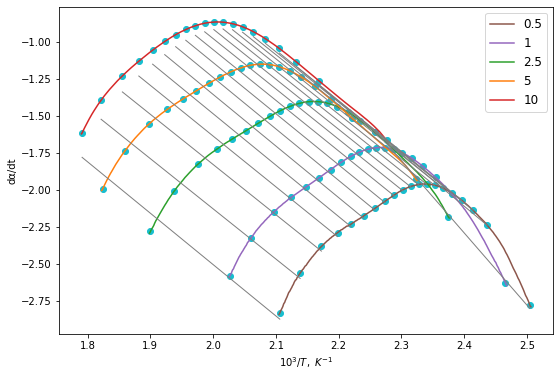

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cycler import cycler
from scipy import integrate, interpolate
from scipy.stats import linregress
from scipy import constants
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'legend.fontsize': 12})
import os
import tkinter as tk
from tkinter import filedialog as fd
from tkinter import ttk
from tkinter.messagebox import showinfo
from matplotlib.backends.backend_tkagg import (
    FigureCanvasTkAgg, NavigationToolbar2Tk)
# Implement the default Matplotlib key bindings.
from matplotlib.backend_bases import key_press_handler
from matplotlib.figure import Figure
from idlelib.tooltip import Hovertip
from itertools import cycle


class DSC():
    
    def __init__(self, Location, sheet=None, conversion_from=0.02, conversion_to=0.98):
        self.Location = Location
        self.rate = sheet
        print(self.rate)
        self.conversion_from = conversion_from
        self.conversion_to = conversion_to
        self.interp_data, self.data = self.get_data(self.Location, self.rate, self.conversion_from, self.conversion_to)
        
        #укорачиваем данные
        self.t = np.asarray(self.data.t)
        self.T = np.asarray(self.data['T'])
        self.Inv_T = np.asarray(self.data['1/T'])
        self.conversion = np.asarray(self.data['conversion'])
        self.dx_dt = np.asarray(self.data['dx/dt'])
        self.DSC = np.asarray(self.data.DSC)
        self.peak_position = self.dx_dt.argmax() #находим аргумент максимума скорости конверсии в интррполированном массиве
        self.peak_T = self.T[self.peak_position]
        self.peak_conversion = self.conversion[self.peak_position]
        self.peak_dx_dt = self.dx_dt[self.peak_position]
        
        #получаем значения для различных степеней конверсии
        self.i_t = np.asarray(self.interp_data.t)
        self.i_T = np.asarray(self.interp_data['T'])
        self.i_Inv_T = np.asarray(self.interp_data['1/T'])
        self.i_conversion = np.asarray(self.interp_data['conversion'])
        self.i_dx_dt = np.asarray(self.interp_data['dx/dt'])
    
        
    @staticmethod
    def get_data(Location, sheet, conversion_from, conversion_to):
        #читаем оригинальный файл
        df = pd.read_excel(Location, sheet_name=sheet)
        df.DSC = -df.DSC #переворачиваем кривую ДСК

        df['T'] = df['T'] + 273.15
        df = df[['T', 't', 'DSC']] # обрезали лишнее в датафрейме

        new_time = np.linspace(df.t.iloc[0], df.t.iloc[-1], 1000) #создали массив времен от первого до последнего с фиксированной длиной для всех файлов данных
        
        f_DSC = interpolate.interp1d(np.asarray(df.t), np.asarray(df.DSC))
        f_T = interpolate.interp1d(np.asarray(df.t), np.asarray(df['T']))
        
        #наэкстраполировали новые данные ДСК и температуры для новых значений времени и создали из них короткий датафрэйм short_df
        new_DSC = f_DSC(new_time)
        new_T = f_T(new_time)
        new_array = np.dstack([new_T, new_time, new_DSC])
        new_array = np.squeeze(new_array, axis=0)
        
        short_df = pd.DataFrame(new_array, columns=['T', 't', 'DSC'])
        
        short_df['1/T'] = 1 / (short_df['T']) 
        short_df['conversion'] = DSC.integr(short_df)
        short_df['DSC'] = new_DSC
        short_df = short_df[(short_df.conversion > 0.019) & (short_df.conversion < 0.981)].reset_index()
        short_df['dx/dt'] = np.gradient(short_df.conversion, short_df.t)
        short_df['dx/dt'] = np.where(short_df['dx/dt'] > 0, short_df['dx/dt'], -short_df['dx/dt'])
        short_df = short_df.reindex()
        
        #создаем масств различных промежуточных степений конверсии и генерируем для них данные, сохраняем в interp_df
        new_conversion = np.arange(0.1, 1, 0.05) #было (0.1, 1, 0.1)
        new_conversion = np.insert(new_conversion, 0, conversion_from, axis=0)
        new_conversion = np.insert(new_conversion, len(new_conversion), conversion_to, axis=0)

        f_time = interpolate.interp1d(short_df.conversion, short_df.t)
        f_T = interpolate.interp1d(short_df.conversion, short_df['T'])
        f_dx_dt = interpolate.interp1d(short_df.conversion, short_df['dx/dt'])
        
        new_time = f_time(new_conversion)
        new_T = f_T(new_conversion)
        new_dx_dt = f_dx_dt(new_conversion)
        
        interp_df = pd.DataFrame()
        interp_df['conversion'] = new_conversion
        interp_df['t'] = new_time
        interp_df['T'] = new_T
        interp_df['1/T'] = 1 / new_T
        interp_df['dx/dt'] = new_dx_dt
        
        return interp_df, short_df
    
    @staticmethod
    def integr(df):
        integr = np.zeros(len(df))
        integr[0] = 0
        for i in range(1, len(df)-1):
            integr[i] = integr[i-1] + integrate.simpson(df.DSC[i-1:i+1], df.t[i-1:i+1])
            if integr[i] < 0: integr[i] = 0

        integr[-1] = integr[-2]
        integr /= integr[-1]
        integr = np.where(integr>1, 1, integr)
        return integr
    
    
class Multiple_DSC():
    def __init__(self, Location, conversion_from=0.02, conversion_to=0.98):
        self.Location = Location
        self.file = pd.ExcelFile(Location)
        self.rates = self.file.sheet_names
        self.int_rates = list(map(float, self.rates)) #скорости нагрева числами, а не текстом
        self.all = {rate: DSC(self.Location, rate, conversion_from, conversion_to) for rate in self.rates}
        self.conversions = self.all[self.rates[0]].i_conversion #массив с конверсиями (взят из первого эксперимента)
        self.Inv_Temps = np.asarray([1000*self.all[rate].i_Inv_T for rate in self.rates]).T #умноженные на 1000
        self.Temps = 1000/self.Inv_Temps.T #нормальные температуры
          
        self.dx_dts = np.asarray([self.all[rate].i_dx_dt for rate in self.rates]).T
        self.slopes = np.asarray([self.get_slopes(self.Inv_Temps[i], np.log(self.dx_dts[i])) for i in range(len(self.Inv_Temps))])
        self.Ea = -self.slopes * constants.R
        
        self.peak_Ts = np.asarray([self.all[rate].peak_T for rate in self.rates])
        self.peak_conversions = np.asarray([self.all[rate].peak_conversion for rate in self.rates])
        self.peak_dx_dts = np.asarray([self.all[rate].peak_dx_dt for rate in self.rates])
        self.Ea_Ozawa = self.calc_Ozawa()
        self.Ea_FWO = self.calc_FWO()
        self.Ea_KAS = self.calc_KAS()
        
        
    def calc_Ozawa(self): #+
        slope = linregress(1/self.peak_Ts, -np.log(self.int_rates))[:1][0] #0 для того, чтобы извлечю значение из tuple
        return slope * constants.R / 1.052 / 1000
    
    
    def plot_Ozawa(self): #+
        fig, ax = plt.subplots(figsize=(8,6))
        ax.plot(1000/self.peak_Ts, -np.log(np.asarray(self.int_rates)), 'or')
        slope, intercept = linregress(1000/self.peak_Ts, -np.log(self.int_rates))[:2]
        Ts_for_interp = np.asarray([1000/self.peak_Ts[0], 1000/self.peak_Ts[-1]])
        ax.plot(Ts_for_interp, slope*Ts_for_interp+intercept)
        x_pos = (1000/self.peak_Ts[0] - 1000/self.peak_Ts[-1]) / 5 * 3 + 1000/self.peak_Ts[-1]
        y_pos = (-np.log(np.asarray(self.int_rates[0])) + np.log(np.asarray(self.int_rates[-1]))) / 15 - np.log(np.asarray(self.int_rates[-1]))
        ax.text(x_pos, y_pos, '$E_a$ = {:5.2f}, kJ/mol'.format(self.Ea_Ozawa), fontsize=18)
        
        plt.xlabel(r'$10^3/T,\ 1/K$')
        plt.ylabel('-ln(\u03B2)')
    
    #FWO
    def calc_FWO(self): #+
        slopes = np.asarray([linregress(self.Inv_Temps[i], -np.log(self.int_rates))[:1][0] for i in range(len(self.Inv_Temps))]) #0 для того, чтобы извлечь значение из tuple
        Ea_FWO = slopes * constants.R / 1.052
        return Ea_FWO
        

    def plot_FWO(self): #+
        custom_cycler = (cycler(marker=["o", '<'])) * (cycler(color='bgrcmyk'))
        fig, ax = plt.subplots(figsize=(8,6))
        ax.set_prop_cycle(custom_cycler)
        for i in range(len(self.Inv_Temps)):
            x = self.Inv_Temps[i]
            y = -np.log(self.int_rates)
            slope, intercept = linregress(x, y)[:2]
            Ts_for_interp = np.asarray([x[0], x[-1]])
            ax.plot(Ts_for_interp, slope*Ts_for_interp+intercept, 'k-', lw=1)
            ax.plot(x, y, lw=0, label='{:2.2f}'.format(self.conversions[i]))
    
        plt.xlim(right=self.Inv_Temps[0][0] + 0.25*(self.Inv_Temps[0][0] - self.Inv_Temps[-1][-1]))
        plt.xlabel(r'$10^3/T,\ 1/K$')
        plt.ylabel('-ln(\u03B2)')
        plt.legend(loc='lower right')   
    
    
    def plot_Ea_FWO(self):  #+
        fig, ax = plt.subplots(figsize=(8,6))
        ax.plot(self.conversions, self.Ea_FWO, 'r')
        plt.xlabel('\u03B1')
        plt.ylabel('$E_a$, kJ/mol')
        
        
        
       #KAS 
    def calc_KAS(self): #+
        slopes = np.asarray([linregress(self.Inv_Temps[i], -np.log(self.int_rates*(self.Inv_Temps[i]**2)))[:1][0] for i in range(len(self.Inv_Temps))]) #0 для того, чтобы извлечь значение из tuple
        Ea_KAS = slopes * constants.R
        return Ea_KAS
    
    
    def plot_KAS(self): #+
        custom_cycler = (cycler(marker=["o", '<'])) * (cycler(color='bgrcmyk'))
        fig, ax = plt.subplots(figsize=(8,6))
        ax.set_prop_cycle(custom_cycler)
        for i in range(len(self.Inv_Temps)):
            x = self.Inv_Temps[i]
            y = -np.log(self.int_rates*(self.Inv_Temps[i]**2))
            slope, intercept = linregress(x, y)[:2]
            Ts_for_interp = np.asarray([x[0], x[-1]])
            ax.plot(Ts_for_interp, slope*Ts_for_interp+intercept, 'k-', lw=1)
            ax.plot(x, y, lw=0, label='{:2.2f}'.format(self.conversions[i]))
    
        plt.xlim(right=self.Inv_Temps[0][0] + 0.25*(self.Inv_Temps[0][0] - self.Inv_Temps[-1][-1]))
        plt.xlabel(r'$10^3/T,\ 1/K$')
        plt.ylabel(r'$-ln(\beta/T^2(\alpha))$')
        plt.legend(loc='lower right')
    
    
    def plot_Ea_KAS(self): #+
        fig, ax = plt.subplots(figsize=(8,6))
        ax.plot(self.conversions, self.Ea_KAS, 'r')
        plt.xlabel('\u03B1')
        plt.ylabel('$E_a$, kJ/mol')
    #end KAS
        
    def conversions_vs_t(self): #+
        custom_cycler = (cycler(color=['c', 'm', 'y', 'k', 'r']))
        fig, ax = plt.subplots(figsize=(8,6))
        ax.set_prop_cycle(custom_cycler)
        #times = {}
        for rate in self.file.sheet_names:
            ax.plot(self.all[rate].t, self.all[rate].conversion, label=rate)
            ax.plot(self.all[rate].i_t, self.all[rate].i_conversion, 'co')
        plt.xlabel('time, min')
        plt.ylabel('\u03B1')
        plt.legend()
        
    def conversions_vs_T(self): #+
        custom_cycler = (cycler(color=['c', 'm', 'y', 'k', 'r']))
        fig, ax = plt.subplots(figsize=(8,6))
        ax.set_prop_cycle(custom_cycler)
        for rate in self.file.sheet_names:
            ax.plot(self.all[rate].T, self.all[rate].conversion, label=rate)
            ax.plot(self.all[rate].i_T, self.all[rate].i_conversion, 'co')
        plt.xlabel('T, K')
        plt.ylabel('\u03B1')
        plt.legend()
    
    def dx_dt_InvT(self):  #+
        custom_cycler = (cycler(color=['c', 'm', 'y', 'k', 'r']))
        fig, ax = plt.subplots(figsize=(8,6))
        ax.set_prop_cycle(custom_cycler)
        for rate in self.file.sheet_names:
            ax.plot(1000*self.all[rate].Inv_T, np.log10(self.all[rate].dx_dt),  label=rate)
            ax.plot(1000*self.all[rate].i_Inv_T, np.log10(self.all[rate].i_dx_dt), 'co')
        self.draw_line(self.Inv_Temps, self.dx_dts) 
        plt.xlabel(r'$10^3/T,\ 1/K$')
        plt.ylabel('d\u03B1/dt')
        plt.legend()
        
        
    def draw_line(self, Inv_Temps, dx_dts): #+
        for i in range(len(Inv_Temps)):            
            slope, intercept = linregress(Inv_Temps[i], np.log10(dx_dts[i]))[:2] # 2 чтобы не выдавал лишние данные в регрессии
            new_Inv_T = np.array([Inv_Temps[i][0], Inv_Temps[i][-1]]) #берем только первую и последнюю точки для каждой скорости нагрева, чтобы через них провести кривую
            plt.plot(new_Inv_T, new_Inv_T*slope + intercept, 'm')
        
        
    def dx_dt_conversion(self): #+
        custom_cycler = (cycler(color=['c', 'm', 'y', 'k', 'r']))
        fig, ax = plt.subplots(figsize=(8,6))
        ax.set_prop_cycle(custom_cycler)
        for rate in self.file.sheet_names:
            ax.plot(self.all[rate].conversion, self.all[rate].dx_dt,  label=rate)
        plt.xlabel('\u03B1')
        plt.ylabel('d\u03B1/dt')
        plt.legend()
    
    
    def DSC_T(self): #+
        custom_cycler = (cycler(color=['c', 'm', 'y', 'k', 'r']))
        fig, ax = plt.subplots(figsize=(8,6))
        ax.set_prop_cycle(custom_cycler)
        for rate in self.file.sheet_names:
            ax.plot(self.all[rate].T, self.all[rate].DSC, label=rate)
        plt.xlabel('T, K')
        plt.ylabel('DSC')
        plt.legend()
        
            
    
    def get_slopes(self, x, y): #получаем наклона изоконверсионных прямых в натурально-логарифмических координатах
        slope_ln, intercept = linregress(x, y)[:2]
        return slope_ln
    
    
    def plot_Ea(self):
        fig, ax = plt.subplots(figsize=(8,6))
        ax.plot(self.conversions, self.Ea, 'r')
        plt.xlabel('\u03B1')
        plt.ylabel('$E_a$, kJ/mol')
        
    
    
    def Eas(self):
        fig, ax = plt.subplots(figsize=(8,6))
        ax.plot(self.conversions, self.Ea, 'm', label='Friedman')
        ax.plot(self.conversions, self.Ea_KAS, 'b', label='KAS')
        ax.plot(self.conversions, self.Ea_FWO, 'r', label='FWO')
        
        plt.xlabel('\u03B1')
        plt.ylabel('$E_a$, kJ/mol')
        ax.legend()
    


class Help(tk.Toplevel):
    def __init__(self):
        super().__init__()
        self.title('Методы обработки:')
        self.geometry('500x400')
        self.resizable(0, 0)
        frame_width = 110

        self.frame1 = tk.Frame(self, bg='white') #left frame with buttons
        self.canvas1 = tk.Canvas(self.frame1, bg="white")
        self.fig1, self.ax1 = plt.subplots(figsize=(8,6), facecolor=(1, 1, 1))
        self.canvas1 = FigureCanvasTkAgg(self.fig1, master=self)
        self.canvas1.draw()
        self.canvas1.get_tk_widget().pack(side=tk.LEFT, fill=tk.BOTH, expand=True)
        plt.axis('off')
        self.draw()
        
    def draw(self):
        plt.tight_layout()
        font_text = 16
        font_equation = 22
        font_sub = 14
        self.ax1.text(0, 0.95, 'Метод Фридмана:', fontsize=font_text)
        self.ax1.text(0, 0.84, r'$ln(\frac{d\alpha}{dt}) = ln[Af(\alpha)] - \frac{E_a(\alpha)}{RT}$', fontsize=font_equation)
        self.ax1.text(0, 0.73, 'Метод Флинна-Уолла-Озавы:', fontsize=font_text)
        self.ax1.text(0, 0.62, r'$ln(\beta) = ln(\frac{AE_a(\alpha)}{Rg(\alpha)}) - 5.331 - 1.052\frac{E_a(\alpha)}{RT(\alpha)}$', fontsize=font_equation)
        self.ax1.text(0, 0.51, 'Метод Киссинджера-Акахиры-Суноза.', fontsize=font_text)
        self.ax1.text(0, 0.40, r'$ln(\frac{\beta}{T^2(\alpha)}) = \frac{E_a(\alpha)}{RT(\alpha)} + const$', fontsize=font_equation)
        self.ax1.text(0, 0.29, 'Метод Озавы:', fontsize=font_text)
        self.ax1.text(0, 0.18, r'$ln(\beta) = ln(\frac{AE_a}{Rg}) - 5.331 - 1.052\frac{E_a}{RT_m}$', fontsize=font_equation)
        self.ax1.text(0, 0.07, r'$где\ T_m -\ температура,\ соответствующая\ максимальной$', fontsize=font_sub)
        self.ax1.text(0, 0.0, r'$\ скорости\ конверсии,\ T(\alpha) - определенной\ конверсии.$', fontsize=font_sub)
    
    

class App(tk.Tk):
    def __init__(self):
        super().__init__()
        self.title('DSC')
        self.geometry('750x520')
        frame_width = 110
        self.variable = tk.IntVar()
        self.variable.set(None) 
        self.frame = tk.Frame(self, bg='white', width=frame_width) #left frame with buttons
        self.button1 = tk.Radiobutton(self.frame, text='\u03B1 (t)', command=self.conversions_vs_t, bg='white', height=2, width=frame_width, variable=self.variable, indicatoron=0, value=10)
        self.button2 = tk.Radiobutton(self.frame, text='\u03B1 (T)', command=self.conversions_vs_T, bg='white', height=2, width=frame_width, variable=self.variable, indicatoron=0, value=1)
        self.button3 = tk.Radiobutton(self.frame, text='d\u03B1/dt (10\u00B3/T)', command=self.dx_dt_InvT, bg='white', height=2, width=frame_width, variable=self.variable, indicatoron=0, value=2)
        self.button4 = tk.Radiobutton(self.frame, text='E\u2090 (\u03B1) Friedman', command=self.plot_Ea, bg='white', height=2, width=frame_width, variable=self.variable, indicatoron=0, value=3)
        self.button5 = tk.Radiobutton(self.frame, text='Ozawa', command=self.plot_Ozawa, bg='white', height=2, width=frame_width, variable=self.variable, indicatoron=0, value=4)
        self.button6 = tk.Radiobutton(self.frame, text='DSC (T)', command=self.DSC_T, bg='white', height=2, width=frame_width, variable=self.variable, indicatoron=0, value=5)
        self.button7 = tk.Radiobutton(self.frame, text='d\u03B1/dt (\u03B1)', command=self.dx_dt_conversion, bg='white', height=2, width=frame_width, variable=self.variable, indicatoron=0, value=6)
        self.button8 = tk.Radiobutton(self.frame, text='-ln(\u03B2) (10\u00B3/T)', command=self.plot_FWO, bg='white',  height=2,width=frame_width, variable=self.variable, indicatoron=0, value=7)
        self.button9 = tk.Radiobutton(self.frame, text='E\u2090 FWO', command=self.plot_Ea_FWO, bg='white', height=2, width=frame_width, variable=self.variable, indicatoron=0, value=8)
        self.button10 = tk.Radiobutton(self.frame, text='E\u2090s Fr/KAS/FWO', command=self.Eas, bg='white', height=2, width=frame_width, variable=self.variable, indicatoron=0, value=9)
        self.button11 = tk.Radiobutton(self.frame, text='DSC (t)', command=self.DSC_t, bg='white', height=2, width=frame_width, variable=self.variable, indicatoron=0, value=0)
        self.button12 = tk.Radiobutton(self.frame, text='-ln(\u03B2/T\u00B2) (10\u00B3/T)', command=self.plot_KAS, bg='white', height=2, width=frame_width, variable=self.variable, indicatoron=0, value=11)
        self.button13 = tk.Radiobutton(self.frame, text='E\u2090 KAS', command=self.plot_Ea_KAS, bg='white', height=2, width=frame_width, variable=self.variable, indicatoron=0, value=12)
        
        self.frame.pack(side=tk.LEFT, fill=tk.Y) 
        self.frame.pack_propagate(0)
        self.button11.pack(side=tk.TOP)
        self.button6.pack(side=tk.TOP)
        self.button1.pack(side=tk.TOP)
        self.button2.pack(side=tk.TOP)
        self.button3.pack(side=tk.TOP)
        self.button4.pack(side=tk.TOP)
        self.button5.pack(side=tk.TOP)
        self.button7.pack(side=tk.TOP)
        self.button8.pack(side=tk.TOP)
        self.button9.pack(side=tk.TOP)
        self.button12.pack(side=tk.TOP)
        self.button13.pack(side=tk.TOP)
        self.button10.pack(side=tk.TOP)

        self.separator = ttk.Separator(self, orient='vertical')
        self.separator.pack(side=tk.LEFT, fill=tk.Y)
        self.frame_for_label = tk.Frame(self, bg='white', height=44) #right frame label
        self.frame_for_label.pack(side=tk.TOP, fill=tk.X)
        self.frame_for_label.pack_propagate(0)
        self.label = tk.Label(self.frame_for_label, bg='white', font='Arial 16', text='Скорость изменения степени конверсии \n от обратной температуры')
        self.label.pack()
        
        self.frame_for_canvas = tk.Frame(self, bg='white') #right frame with graph
        self.frame_for_canvas.pack(side=tk.TOP, fill=tk.X)
        
        self.menu = tk.Menu(self)
        self.filemenu = tk.Menu(self.menu, tearoff=0)
        self.filemenu.add_command(label="Открыть", command=self.open_file)
        self.filemenu.add_command(label="Экспрот", command=self.save)
        self.filemenu.add_command(label="Выход", command=self.destroy)
        self.menu.add_cascade(label="Файл", menu=self.filemenu)
        
        self.forecast_menu = tk.Menu(self.menu, tearoff=0)
        self.forecast_menu.add_command(label='Сделать прогноз', command=self.open_forecast)
        self.menu.add_cascade(label='Прогноз', menu=self.forecast_menu)
         
        self.helpmenu = tk.Menu(self.menu, tearoff=0)
        self.helpmenu.add_command(label="Как это работает:", command=self.open_help)
        self.menu.add_cascade(label="Помощь", menu=self.helpmenu)
        
        self.config(menu=self.menu)         
        
        
        self.canvas = tk.Canvas(self.frame_for_canvas, bg="white")
        self.fig, self.ax = plt.subplots(figsize=(8,6), facecolor=(1, 1, 1))
        self.canvas = FigureCanvasTkAgg(self.fig, master=self)
        self.canvas.draw()
        self.toolbar = NavigationToolbar2Tk(self.canvas, self)
        self.toolbar.config(background='white')
        self.toolbar.update()
        self.canvas.get_tk_widget().pack(side=tk.LEFT, fill=tk.BOTH, expand=True)
        
        self.tip10 = Hovertip(self.button10, 'Зависимости энергий активации \nот степени конверсии, полученные методами \nФридмана и Флинна-Уолла-Озавы', hover_delay=100) #всплывающее описание
        self.custom_cycler = (cycler(color=['tab:brown', 'tab:purple',  'tab:green', 'tab:orange', 'tab:red']))
        
    
           
    def open_file(self):
        self.Location = tk.filedialog.askopenfilename(initialdir=os.getcwd(), title="Please select a file:")
        print(self.Location)
        self.data = Multiple_DSC(self.Location, conversion_from=0.02, conversion_to=0.98)
        self.DSC_t()
        self.variable.set(0)
    
    
    def open_help(self):
        app1 = Help()
        app1.mainloop()
        
        
    def open_forecast(self):
        app2 = Forecast(self.data)
        app2.attributes('-topmost', 'true')
        app2.mainloop()
        
    
    def conversions_vs_t(self):
        self.fig.clear()
        self.ax = self.fig.add_subplot(111)
        self.ax.set_prop_cycle(self.custom_cycler)

        for rate in self.data.file.sheet_names:
            self.ax.plot(self.data.all[rate].t, self.data.all[rate].conversion, label=rate)
            self.ax.scatter(self.data.all[rate].i_t, self.data.all[rate].i_conversion, color='tab:cyan')
        
        self.label.config(text='Степень конверсии от времени.')
        self.ax.set_xlabel('time, min')
        self.ax.set_ylabel('\u03B1')
        self.ax.legend()
        self.canvas.draw_idle()


    def conversions_vs_T(self):
        #custom_cycler = (cycler(color=['c', 'm', 'y', 'k', 'r']))
        self.fig.clear()
        self.ax = self.fig.add_subplot(111)
        self.ax.set_prop_cycle(self.custom_cycler)
        for rate in self.data.file.sheet_names:
            self.ax.plot(self.data.all[rate].T, self.data.all[rate].conversion, label=rate)
            self.ax.scatter(self.data.all[rate].i_T, self.data.all[rate].i_conversion, color='tab:cyan')
        
        self.label.config(text='Степень конверсии от температуры.')

        self.ax.set_xlabel('T, K')
        self.ax.set_ylabel('\u03B1')
        self.ax.legend()
        self.canvas.draw_idle()

    def dx_dt_InvT(self):
        self.fig.clear()
        self.ax = self.fig.add_subplot(111)
        self.ax.set_prop_cycle(self.custom_cycler)
        for rate in self.data.file.sheet_names:
            self.ax.plot(1000*self.data.all[rate].Inv_T, np.log10(self.data.all[rate].dx_dt),  label=rate)
            self.ax.scatter(1000*self.data.all[rate].i_Inv_T, np.log10(self.data.all[rate].i_dx_dt), color='tab:cyan')
        self.draw_line(self.data.Inv_Temps, self.data.dx_dts) 
        
        self.label.config(text='Анализ Фридмана. Скорость изменения степени конверсии\nот обратной температуры.')
        self.ax.set_xlabel(r'$10^3/T,\ K^{-1}$')
        self.ax.set_ylabel('d\u03B1/dt')
        self.ax.legend()
        self.canvas.draw_idle()


    def draw_line(self, Inv_Temps, dx_dts):
        for i in range(len(Inv_Temps)):            
            slope, intercept = linregress(Inv_Temps[i], np.log10(dx_dts[i]))[:2] # 2 чтобы не выдавал лишние данные в регрессии
            new_Inv_T = np.array([Inv_Temps[i][0], Inv_Temps[i][-1]]) #берем только первую и последнюю точки для каждой скорости нагрева, чтобы через них провести кривую
            self.ax.plot(new_Inv_T, new_Inv_T*slope + intercept, color='tab:grey', lw=1)


    def DSC_t(self):
        self.fig.clear()
        self.ax = self.fig.add_subplot(111)
        self.ax.set_prop_cycle(self.custom_cycler)
        for rate in self.data.file.sheet_names:
            self.ax.plot(self.data.all[rate].t, -self.data.all[rate].DSC, label=rate)
        self.ax.set_xlabel('time, min')
        self.ax.set_ylabel(r'$Heatflow, Wg^{-1}$')
        self.ax.legend()
        self.label.config(text='Термограммы ДСК.')
        self.canvas.draw_idle()


    def DSC_T(self):
        self.fig.clear()
        self.ax = self.fig.add_subplot(111)
        self.ax.set_prop_cycle(self.custom_cycler)
        for rate in self.data.file.sheet_names:
            self.ax.plot(self.data.all[rate].T, -self.data.all[rate].DSC, label=rate)
        self.ax.set_xlabel('T, K')
        self.ax.set_ylabel(r'$Heatflow, Wg^{-1}$')
        self.ax.legend()
        self.label.config(text='Сигнал ДСК от температуры.')
        self.canvas.draw_idle()
        
    
    #Friedman
    def dx_dt_conversion(self):
        self.fig.clear()
        self.ax = self.fig.add_subplot(111)
        self.ax.set_prop_cycle(self.custom_cycler)
        for rate in self.data.file.sheet_names:
            self.ax.plot(self.data.all[rate].conversion, self.data.all[rate].dx_dt,  label=rate)
            self.ax.scatter(self.data.all[rate].i_conversion, self.data.all[rate].i_dx_dt, color='tab:cyan')
        self.ax.set_xlabel('\u03B1')
        self.ax.set_ylabel('d\u03B1/dt')
        self.ax.legend()
        self.label.config(text='Скорость изменения степени конверсии от степени конверсии.\nМетод FWO.')
        self.canvas.draw_idle()
        
    
    def plot_Ea(self): 
        self.fig.clear()
        self.ax = self.fig.add_subplot(111)
        self.ax.plot(self.data.conversions, self.data.Ea, 'tab:red')
        self.ax.set_xlabel('\u03B1')
        self.ax.set_ylabel('$E_a$, kJ/mol')
        self.label.config(text='Анализ Фридмана. \n Энергия активации от степени конверсии.')
        self.canvas.draw_idle()
        
    
    #Ozawa
    def plot_Ozawa(self):
        self.fig.clear()
        self.ax = self.fig.add_subplot(111)        
        self.ax.scatter(1000/self.data.peak_Ts, -np.log(np.asarray(self.data.int_rates)), color='tab:cyan')
        slope, intercept = linregress(1000/self.data.peak_Ts, -np.log(self.data.int_rates))[:2]
        Ts_for_interp = np.asarray([1000/self.data.peak_Ts[0], 1000/self.data.peak_Ts[-1]])
        self.ax.plot(Ts_for_interp, slope*Ts_for_interp+intercept, '-', color='tab:grey')
        x_pos = (1000/self.data.peak_Ts[0] - 1000/self.data.peak_Ts[-1]) / 5 * 3 + 1000/self.data.peak_Ts[-1]
        y_pos = (-np.log(np.asarray(self.data.int_rates[0])) + np.log(np.asarray(self.data.int_rates[-1]))) / 15 - np.log(np.asarray(self.data.int_rates[-1]))
        self.ax.text(x_pos, y_pos, '$E_a$ = {:5.2f}, kJ/mol'.format(self.data.Ea_Ozawa), fontsize=18)

        self.ax.set_xlabel(r'$10^3/T,\ K^{-1}$')
        self.ax.set_ylabel('-ln(\u03B2)')
        self.label.config(text='Метод Озавы. Зависимость скорости нагрева от обратной\nтемпературы, соответствующей максимальной скорости реакции.')
        self.canvas.draw_idle()
        
        
    #FWO
    def plot_FWO(self):
        custom_cycler = (cycler(marker=["o", '<'])) * (cycler(color=['tab:purple', 'tab:blue', 'tab:green', 'tab:red', 'tab:orange', 'tab:olive', 'tab:brown']))
        self.fig.clear()
        self.ax = self.fig.add_subplot(111)
        self.ax.set_prop_cycle(custom_cycler)
        for i in range(len(self.data.Inv_Temps)):
            x = self.data.Inv_Temps[i]
            y = -np.log(self.data.int_rates)
            slope, intercept = linregress(x, y)[:2]
            Ts_for_interp = np.asarray([x[0], x[-1]])
            self.ax.plot(Ts_for_interp, slope*Ts_for_interp+intercept, '-', color='tab:grey', lw=1)
            self.ax.plot(x, y, lw=0, label='{:2.2f}'.format(self.data.conversions[i]))

        plt.xlim(right=self.data.Inv_Temps[0][0] + 0.25*(self.data.Inv_Temps[0][0] - self.data.Inv_Temps[-1][-1]))
        self.ax.set_xlabel(r'$10^3/T,\ K^{-1}$')
        self.ax.set_ylabel('-ln(\u03B2)')
        self.ax.legend(loc='lower right')
        self.label.config(text='Метод Флинна-Уолла-Озавы.')
        self.canvas.draw_idle()
        
    
    def plot_Ea_FWO(self):
        self.fig.clear()
        self.ax = self.fig.add_subplot(111)
        self.ax.plot(self.data.conversions, self.data.Ea_FWO, 'tab:red')
        plt.xlabel('\u03B1')
        self.ax.set_ylabel('$E_a$, kJ/mol')
        self.label.config(text='Модель Флинна-Уолла-Озавы. \n Энергия активации от степени конверсии.')
        self.canvas.draw_idle()

        
    #KAS 
    def plot_KAS(self):
        custom_cycler = (cycler(marker=["o", '<'])) * (cycler(color=['tab:purple', 'tab:blue', 'tab:green', 'tab:red', 'tab:orange', 'tab:olive', 'tab:brown']))
        self.fig.clear()
        self.ax = self.fig.add_subplot(111)
        self.ax.set_prop_cycle(custom_cycler)
        for i in range(len(self.data.Inv_Temps)):
            x = self.data.Inv_Temps[i]
            y = -np.log(self.data.int_rates*(self.data.Inv_Temps[i]**2))
            slope, intercept = linregress(x, y)[:2]
            Ts_for_interp = np.asarray([x[0], x[-1]])
            self.ax.plot(Ts_for_interp, slope*Ts_for_interp+intercept, 'k-', lw=1)
            self.ax.plot(x, y, lw=0, label='{:2.2f}'.format(self.data.conversions[i]))
    
        plt.xlim(right=self.data.Inv_Temps[0][0] + 0.25*(self.data.Inv_Temps[0][0] - self.data.Inv_Temps[-1][-1]))
        self.ax.set_xlabel(r'$10^3/T,\ K^{-1}$')
        self.ax.set_ylabel(r'$-ln(\beta/T^2(\alpha))$')
        self.ax.legend(loc='lower right')
        self.label.config(text='Метод Киссинджера-Акахиры-Суноза.')
        self.canvas.draw_idle()
    
    
    def plot_Ea_KAS(self):
        self.fig.clear()
        self.ax = self.fig.add_subplot(111)
        self.ax.plot(self.data.conversions, self.data.Ea_KAS, 'r')
        self.ax.set_xlabel('\u03B1')
        self.ax.set_ylabel('$E_a$, kJ/mol')
        self.label.config(text='Метод Киссинджера-Акахиры-Суноза. \n Энергия активации от степени конверсии.')
        self.canvas.draw_idle()
        
    
    #all
    def Eas(self):
        self.fig.clear()
        self.ax = self.fig.add_subplot(111)
        self.ax.plot(self.data.conversions, self.data.Ea_FWO, 'tab:red', label='FWO')
        self.ax.plot(self.data.conversions, self.data.Ea_KAS, 'tab:blue', label='KAS')
        self.ax.plot(self.data.conversions, self.data.Ea, 'tab:purple', label='Friedman')
        self.ax.set_xlabel('\u03B1')
        self.ax.set_ylabel('$E_a$, kJ/mol')
        self.ax.legend()
        self.label.config(text='Зависимости энергий активации от степени конверсии, \n полученные методами Фридмана, FWO и KAS.')
        self.canvas.draw_idle()
        
    
    #save
    def save(self):
        files = [('Excel Files', '*.xlsx')]
        data = {self.data.rates[i]: self.data.Inv_Temps.T[i] for i in range(len(self.data.Inv_Temps.T))}
        conv = pd.DataFrame({'\u03B1': self.data.conversions})
        df1 = pd.DataFrame({'Friedman': self.data.Ea, 'FWO': self.data.Ea_FWO, 'KAS': self.data.Ea_KAS})

        df = pd.concat({'conversion': conv, "1000/T": pd.DataFrame(data), 'Ea': df1}, axis=1, names=["l1", "l2"])
        SaveLocation = tk.filedialog.asksaveasfilename(initialdir=os.getcwd(),
                                                   filetypes = files, 
                                                    defaultextension = files)
        print(SaveLocation)
        df.to_excel(SaveLocation)


            
class Forecast(tk.Toplevel):
     
    def __init__(self, data):
        super().__init__()
        self.data = data
        self.rates = np.asarray(self.data.int_rates) / 60
        self.title('Прогнозирование изотермической реакции')
        frame_width = 110
        width = 600
        height = 500
        self.geometry(str(width)+'x'+str(height))  
        self.left_frame = tk.Frame(self, bg='white', width=frame_width)
        self.separator = ttk.Separator(self, orient='horizontal')
        self.separator.pack(side=tk.LEFT, fill=tk.Y)
        

        self.var = tk.IntVar()
        self.var.set(-1) 
        self.button0 = tk.Radiobutton(self.left_frame, text='Вязовкин', bg='white', height=2, width=frame_width, variable=self.var, indicatoron=0, value=0)
        self.button1 = tk.Radiobutton(self.left_frame, text='FWO', bg='white', height=2, width=frame_width, variable=self.var, indicatoron=0, value=1)
        self.button2 = tk.Radiobutton(self.left_frame, text='KAS', bg='white', height=2, width=frame_width, variable=self.var, indicatoron=0, value=2)
        self.button3 = tk.Radiobutton(self.left_frame, text='Все', bg='white', height=2, width=frame_width, variable=self.var, indicatoron=0, value=3)
        self.empty_frame = tk.Frame(self.left_frame, bg='white', height=20)
        self.label = tk.Label(self.left_frame, bg='white', font='Arial 10', text="Введите \nтемпературу (\xb0С):")
        self.entry = tk.Entry(self.left_frame, bg='yellow')
        self.save_button = tk.Button(self.left_frame, bg='white', command=self.save_forecast, font='Arial 10', text="Сохранить")
        self.confirm_button = tk.Button(self.left_frame, bg='white', command=self.confirm, font='Arial 10', text="Подтвердить")

        
        self.left_frame.pack(side=tk.LEFT, fill=tk.Y)
        self.left_frame.pack_propagate(0)
        self.button0.pack(side=tk.TOP)
        self.button1.pack(side=tk.TOP)
        self.button2.pack(side=tk.TOP)
        self.button3.pack(side=tk.TOP)
            
        self.empty_frame.pack(side=tk.TOP)
        self.label.pack(side=tk.TOP)
        self.entry.pack(side=tk.TOP, padx = 0.0, pady=0)
        self.save_button.pack(side=tk.BOTTOM, fill=tk.X)
        self.confirm_button.pack(side=tk.BOTTOM, fill=tk.X)
        self.confirm_button.pack_propagate(0)
        
        #graph canvas
        self.frame_for_canvas = tk.Frame(self, bg='white') #right frame with graph
        self.frame_for_canvas.pack(side=tk.TOP, fill=tk.X)
        
        self.canvas = tk.Canvas(self.frame_for_canvas, bg="white")
        self.fig, self.ax = plt.subplots(figsize=(8,6), facecolor=(1, 1, 1))
        self.canvas = FigureCanvasTkAgg(self.fig, master=self)
        self.canvas.draw()
        self.toolbar = NavigationToolbar2Tk(self.canvas, self)
        self.toolbar.config(background='white')
        self.toolbar.update()
        self.canvas.get_tk_widget().pack(side=tk.LEFT, fill=tk.BOTH, expand=True)
        
    #FWO
    def get_times_FWO(self, T):
        Ea_FWO = self.data.Ea_FWO * 1000
        times_FWO = np.zeros(self.data.Temps.shape)
        
        for i, item in enumerate(self.rates):
            times_FWO[i] = Ea_FWO / item / constants.R * np.exp(Ea_FWO / constants.R / T - 1.0518 * Ea_FWO / constants.R / self.data.Temps[i] - 5.3305)
        return times_FWO
    
    
    def FWO_forecast(self):
        self.times_FWO = self.get_times_FWO(273.15+self.Temp)
    
    
    def plot_FWO_forecast(self):
        self.times_FWO = self.get_times_FWO(273.15+self.Temp)
        mycycle = cycle(self.data.int_rates)
        self.fig.clear()
        self.ax = self.fig.add_subplot(111)
        for time in self.times_FWO:
            self.ax.plot(time/3600, self.data.conversions, label=next(mycycle))
            self.ax.set_xlabel('time, h.')
            self.ax.set_ylabel('\u03B1')
        self.ax.grid()
        self.ax.legend()
        self.canvas.draw_idle()
        
    #end FWO
    
    
    #KAS
    def get_times_KAS(self, T):
        Ea_KAS = self.data.Ea_KAS * 1000
        times_KAS = np.zeros(self.data.Temps.shape)
        for i, item in enumerate(self.rates):
            times_KAS[i] = constants.R * self.data.Temps[i]**2 * np.exp(Ea_KAS / constants.R / T - Ea_KAS / constants.R / self.data.Temps[i]) / item / Ea_KAS
        return times_KAS
    
    
    def KAS_forecast(self):
        self.times_KAS = self.get_times_KAS(273.15+self.Temp)
        
        
    def plot_KAS_forecast(self):
        self.times_KAS = self.get_times_KAS(273.15+self.Temp)

        mycycle = cycle(self.data.int_rates)
        self.fig.clear()
        self.ax = self.fig.add_subplot(111)
        for time in self.times_KAS:
            self.ax.plot(time/3600, self.data.conversions, label=next(mycycle))
        self.ax.set_xlabel('time, h.')
        self.ax.set_ylabel('\u03B1')
        self.ax.grid()
        self.ax.legend()
        self.canvas.draw_idle()
    #end KAS
    
    #Vyazovkin
    def get_times_Vyazovkin(self, T):
        print(T)
        Ea = self.data.Ea_FWO #* 1000
        to_integrate = np.exp(-Ea / self.data.Temps / constants.R)
        integrals = np.zeros(to_integrate.shape)
        for i in range(len(self.data.Temps)):
            print(len(self.data.Temps))
            for j in range(1, len(self.data.Temps[i])):

                integrals[i, j] = integrals[i, j-1] + integrate.simpson(to_integrate[i, j-1:j+1], self.data.Temps[i, j-1:j+1])#!!!!
        self.times_Vyazovkin = np.zeros(self.data.Temps.shape) #вязовкин
        
        for i, rate in enumerate(self.data.int_rates):
            self.times_Vyazovkin[i] = integrals[i] / rate / np.exp(-Ea / constants.R / T)
        return self.times_Vyazovkin
        
        
    def Vyazovkin_forecast(self):
        self.times_Vyazovkin = self.get_times_Vyazovkin(273.15 + self.Temp)
    
    
    def plot_Vayzovkin_forecast(self):
        self.times_Vyazovkin = self.get_times_Vyazovkin(273.15 + self.Temp)
        mycycle = cycle(self.data.int_rates)
        self.fig.clear()
        self.ax = self.fig.add_subplot(111)
        for time in self.times_Vyazovkin:
            self.ax.plot(time/3600, self.data.conversions, label=next(mycycle))
        self.ax.set_xlabel('time, h.')
        self.ax.set_ylabel('\u03B1')
        self.ax.grid()
        self.ax.legend()
        self.canvas.draw_idle()
    #end Vyazovkin 
    
    #строим все графики
    def plot_all(self):

        mean_Vyazovkin_times = self.times_Vyazovkin.mean(axis=0)
        mean_FWO_times = self.times_FWO.mean(axis=0)
        mean_KAS_times = self.times_KAS.mean(axis=0)
        self.all_times=[mean_Vyazovkin_times, mean_FWO_times, mean_KAS_times]

        
        mycycle = cycle(['Vyazovkin', 'FWO', 'KAS'])
        self.fig.clear()
        self.ax = self.fig.add_subplot(111)
        for time in self.all_times:
            self.ax.plot(time/3600, self.data.conversions, label=next(mycycle))
        self.ax.set_xlabel('time, h.')
        self.ax.set_ylabel('\u03B1')
        self.ax.grid()
        self.ax.legend()
        self.canvas.draw_idle()
        
    def confirm(self):
        self.Temp = self.entry.get()
        
        try:
            self.Temp = float(self.Temp)
        except: 
            tk.messagebox.showinfo("Ошибка", "Введите корректную величину!")
            pass
        
        if isinstance(self.Temp, float) or isinstance(self.Temp, int):
            cond1 = self.Temp < -273
            if cond1:
                tk.messagebox.showinfo("Ошибка", "Значение температуры ниже допустимой величины!")
            else:
                if self.var.get()==1:
                    self.plot_FWO_forecast()
                elif self.var.get()==2:
                    self.plot_KAS_forecast()
                elif self.var.get()==0:
                    self.plot_Vayzovkin_forecast()
                elif self.var.get()==3:
                    self.KAS_forecast()
                    self.FWO_forecast()
                    self.Vyazovkin_forecast()
                    self.plot_all()
                else: tk.messagebox.showinfo("Ошибка", "Выберите алгоритм прогнозирования!")
                #do something
    
    #save
    def save_forecast(self):
        files = [('Excel Files', '*.xlsx')]
        
        self.Temp = self.entry.get()
        try:
            self.Temp = float(self.Temp)
        except: 
            tk.messagebox.showinfo("Ошибка", "Введите корректную величину!")
            pass
        
        if isinstance(self.Temp, float) or isinstance(self.Temp, int):
            cond1 = self.Temp < -273
            if cond1:
                tk.messagebox.showinfo("Ошибка", "Значение температуры ниже допустимой величины!")
            else:
                self.KAS_forecast()
                self.FWO_forecast()
                self.Vyazovkin_forecast()
        
        conv = pd.DataFrame({'\u03B1': self.data.conversions})
        data_Vyazovkin = {self.data.rates[i]: self.times_Vyazovkin[i]/3600 for i in range(len(self.times_Vyazovkin))}
        data_FWO = {self.data.rates[i]: self.times_KAS[i]/3600 for i in range(len(self.times_KAS))}
        data_KAS = {self.data.rates[i]: self.times_FWO[i]/3600 for i in range(len(self.times_FWO))}
        
        df = pd.concat({'conversion': conv, 
                        "Vyazovkin": pd.DataFrame(data_Vyazovkin), 
                        'FWO':  pd.DataFrame(data_FWO), 
                        'KAS': pd.DataFrame(data_KAS)}, 
                       axis=1, names=["l1", "l2"])
        
        SaveLocation = tk.filedialog.asksaveasfilename(initialdir=os.getcwd(),
                                                   filetypes = files, 
                                                    defaultextension = files)
        print(SaveLocation)
        df.to_excel(SaveLocation)
        
        


if __name__ == "__main__":
    app = App()
    app.mainloop()
    

